## 2. Baseline

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from tqdm import tqdm 

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import catboost as catb


from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, make_scorer, accuracy_score

import dask.dataframe as dd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#загрузим наш датасет
train_df = pd.read_csv('train_df.csv', sep=',')
test_df = pd.read_csv('test_df.csv', sep=',')

### 2.1 Построим baseline

In [4]:
print("ID пользователя уникален: ", train_df['id'].is_unique)
print("Есть ли дубли в строках:", train_df.duplicated().sum())
print("Процент признаков с null-значениями: %d%%" % float((train_df.isnull().sum() > 0).sum()/train_df.shape[1]*100))

ID пользователя уникален:  False
Есть ли дубли в строках: 0
Процент признаков с null-значениями: 0%


In [5]:
print("ID пользователя уникален: ", test_df['id'].is_unique)
print("Есть ли дубли в строках:", test_df.duplicated().sum())
print("Процент признаков с null-значениями: %d%%" % float((test_df.isnull().sum() > 0).sum()/test_df.shape[1]*100))

ID пользователя уникален:  False
Есть ли дубли в строках: 0
Процент признаков с null-значениями: 0%


In [6]:
X = train_df.drop(columns='target')
y = train_df['target']

Пропусков в данных нет, построим baseline прямо на сырых данных. В качестве модели возьмем логистическую регрессию

In [7]:
#Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 54

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

In [9]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((665322, 256), (166331, 256), (665322,), (166331,))

In [10]:
# log_reg = ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
catb_model = ('catb', catb.CatBoostClassifier(silent=True, random_state=RANDOM_STATE))

In [11]:
baseline_estimator = Pipeline([
    catb_model
])

In [12]:
#Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам
kfold_cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def run_cv(estimator, cv, X, y, scoring='f1', model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

Посмотрим на значение метрики на кросс-валидации, оно понадобится для сравнения с последующими моделями.

In [13]:
run_cv(baseline_estimator, kfold_cv, X_train, y_train, model_name="Baseline")

Baseline: f1 = 0.41 (+/- 0.01)


Качество оставляет желать лучшего

### 2.2 Проверка baseline модели на валидационой выборке

In [14]:
baseline_estimator.fit(X_train, y_train)

baseline_y_pred = baseline_estimator.predict_proba(X_valid)[:,1]

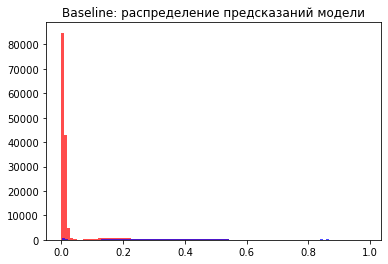

In [15]:
plt.title("Baseline: распределение предсказаний модели")
plt.hist(baseline_y_pred[~y_valid.astype(bool)], bins=100, color='r', alpha=0.7);
plt.hist(baseline_y_pred[y_valid.astype(bool)], bins=100, color='b', alpha=0.7);

In [16]:
fpr, tpr, roc_thresholds = roc_curve(y_valid, baseline_y_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_valid, baseline_y_pred)

Baseline: AUC_ROC = 0.929


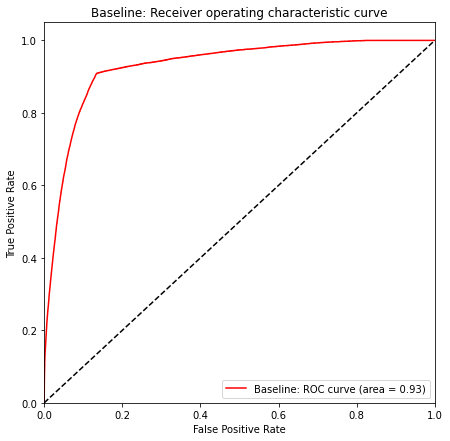

In [17]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "Baseline", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

Baseline: AUC_PR = 0.562


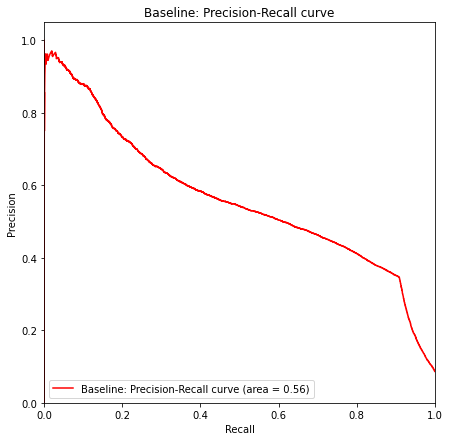

In [18]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "Baseline", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

Baseline получился плохим, будем далее дорабатывать.

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_valid, baseline_y_pred > 0.5))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    154245
         1.0       0.64      0.30      0.41     12086

    accuracy                           0.94    166331
   macro avg       0.79      0.65      0.69    166331
weighted avg       0.93      0.94      0.93    166331



## 3. EDA

### 3.1 Обзор целевой переменной

У нас задача бинарной классификации. Посмотрим на целевую переменную. Она принимает два значения: 1 - пользователь подлючил услугу, 0 - пользователь не подключал предложенную услугу 

In [20]:
features = train_df.columns.drop('target').to_list()

### 3.1 Корреляция целевой переменной с базовыми признаками

In [21]:
corr_with_target = train_df[features + ['target']].corr().iloc[:-1, -1].sort_values(ascending=False)

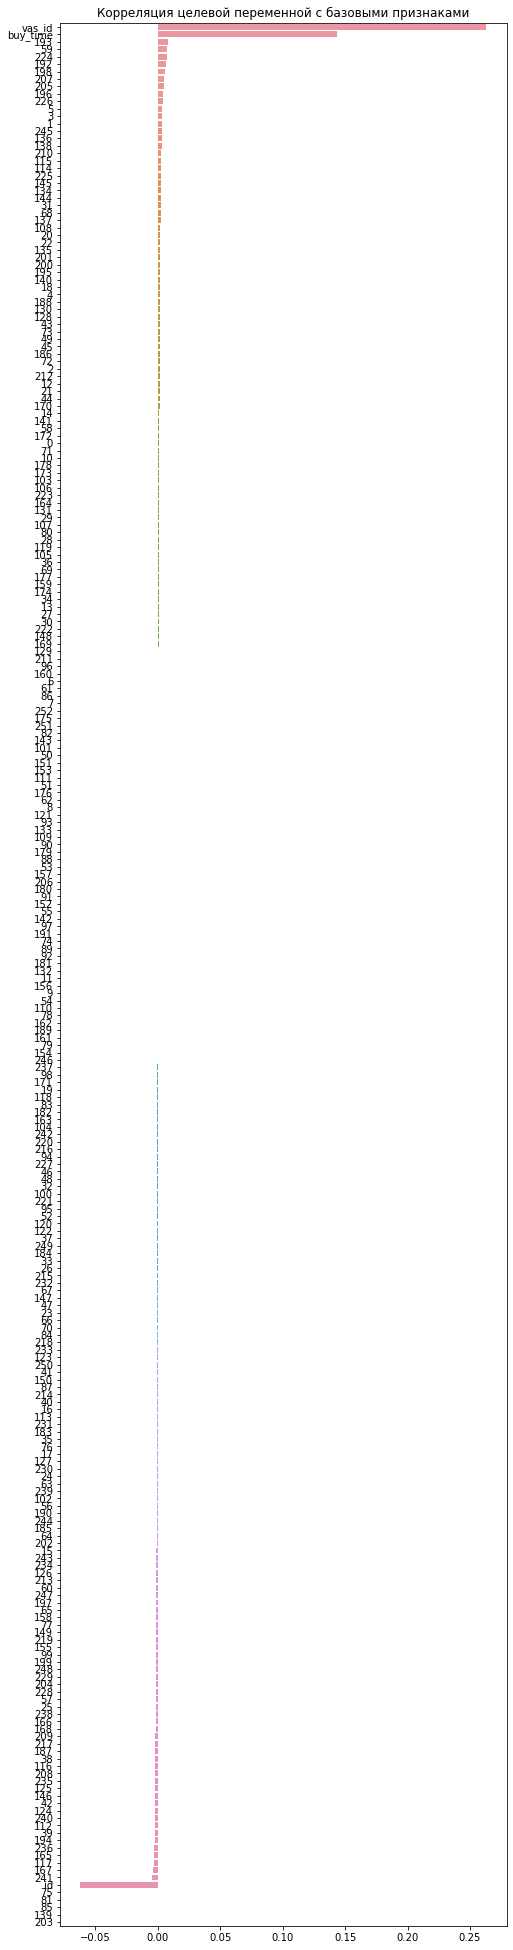

In [22]:
plt.figure(figsize=(8, 35))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Корреляция целевой переменной с базовыми признаками')
plt.show()

Посомтрим на распределение целевой переменной

In [23]:
train_df['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

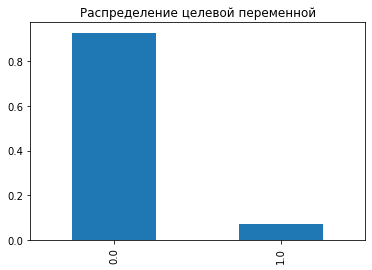

In [24]:
(train_df['target'].value_counts()/train_df['target'].shape[0]).plot(kind='bar', title='Распределение целевой переменной')
train_df['target'].value_counts()/train_df['target'].shape

In [25]:
disbalance = train_df['target'].value_counts()[0] / train_df['target'].value_counts()[1]
print(f'Есть дисбаланс классов в {round(disbalance)} раз.')

Есть дисбаланс классов в 13 раз.


Чтобы убрать дисбаланс классов можно воспользоваться чем-нибудь.

### 3.2 Работа с признаками

In [26]:
# X = train_df.drop(columns='target')
# y = train_df['target']

Посмотрим на пропуски в данных:

In [27]:
X_isna = X.isna().sum()

In [28]:
counter = 0
for value in (X_isna > 0).to_list():
    if value == 'True':
        print('True')
        counter += 1
    else:
        continue
print(f'Число признаков с пропусками: {counter}')

Число признаков с пропусками: 0


In [29]:
X_nunique = X.apply(lambda x: x.nunique(dropna=False))

In [30]:
# Количество признаков
X_nunique.shape

(256,)

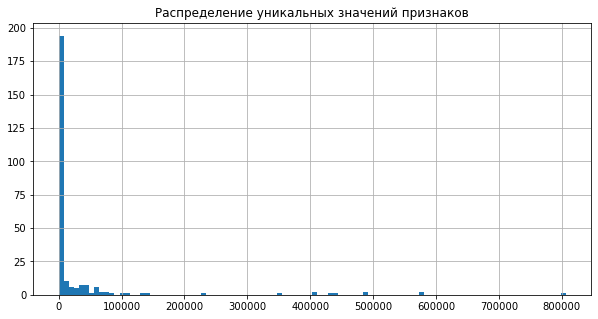

In [31]:
plt.title("Распределение уникальных значений признаков");
X_nunique.hist(bins=100, figsize=(10, 5));

In [32]:
# всего признаков
features_all = set(X_nunique.index.tolist())
len(features_all)

256

#### 3.2.1. Константниые признаки

In [33]:
features_const = set(X_nunique[X_nunique == 1].index.tolist())
len(features_const)

5

Константные признаки нам не интересны, их удаляем

In [34]:
features_other = features_all - features_const
len(features_other)

251

#### 3.2.2 Категориальные признаки

In [35]:
features_cat = set(X_nunique.loc[features_other][X_nunique.loc[features_other] <= 10].index.tolist())
# features_numeric_extra = features_cat

In [36]:
features_other = features_other - features_cat
len(features_other)

221

#### 3.2.3 Бинарные признаки

In [37]:
features_binary = set(X.loc[:, features_other].columns[(
                      (X.loc[:, features_other].max() == 1) & \
                      (X.loc[:, features_other].min() == 0) & \
                      (X.loc[:, features_other].isnull().sum() == 0))])
len(features_binary)

0

In [38]:
features_other = features_other - features_binary
len(features_other)

221

#### 3.2.4 Вещественные признаки

In [39]:
features_num = (X[features_other].fillna(0).astype(int).sum() - X[features_other].fillna(0).sum()).abs()
features_num = set(features_num[features_num > 0].index.tolist())
len(features_num)

215

In [40]:
features_other = features_other - features_num
len(features_other)

6

In [41]:
features_num = features_num | features_other

In [42]:
features_other = features_other - features_num
len(features_other)

0

In [43]:
assert(X_nunique.shape[0] == len(features_const) + len(features_binary) + len(features_num) + len(features_cat))

In [44]:
print('Выводы по признакам')
print()
print(f'Всего признаков (features_all): {X.shape[1]}')
print(f'Константные признаки (features_const): {len(features_const)}')
print(f'Бинарные признаки (features_binary): {len(features_binary)}')
print(f'Категориальные признаки (features_cat): {len(features_cat)}')
print(f'Числовые признаки (features_num): {len(features_num)}')

Выводы по признакам

Всего признаков (features_all): 256
Константные признаки (features_const): 5
Бинарные признаки (features_binary): 0
Категориальные признаки (features_cat): 30
Числовые признаки (features_num): 221


In [45]:
features_ok = list(features_binary | features_cat | features_num)
features_binary, features_cat, features_num = list(features_binary), list(features_cat), list(features_num)

In [46]:
print('features_ok:', len(features_ok))

features_ok: 251


Категориальные признаки будем кодировать OneHotEncoder, числовые признаки стандартизуем StandardScaler, с датой ничего делать не будем.

## 4. Pipeline

In [47]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

Опишем процедуру предобработки признаков:

In [48]:
feature_prep_pipeline = make_pipeline(
        ColumnSelector(columns=features_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(features_num),
            SimpleImputer(strategy="median"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(features_cat),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore') # handle_unknown игнорировать значения в тесте если их не было в трейне
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(features_binary),
        ))
    ])
)

In [49]:
#Посмотрим на шаги пайплайна
feature_prep_pipeline.steps

[('columnselector',
  ColumnSelector(columns=['233', '156', '28', '213', '112', '108', '115', '144',
                          '247', '31', '0', '180', '38', '155', '187', '12',
                          '216', '135', '30', '229', '145', '48', '201', '143',
                          '127', '124', '205', '74', '67', '23', ...])),
 ('featureunion',
  FeatureUnion(transformer_list=[('numeric_features',
                                  Pipeline(steps=[('columnselector',
                                                   ColumnSelector(columns=['233',
                                                                           '156',
                                                                           '28',
                                                                           '213',
                                                                           '112',
                                                                           '108',
                                     

In [50]:
print('Количество признаков до предобработки:')
X_valid.shape[1]

Количество признаков до предобработки:


256

In [51]:
#Обучим модель
feature_prep_pipeline.fit(X_train)

Pipeline(steps=[('columnselector',
                 ColumnSelector(columns=['233', '156', '28', '213', '112',
                                         '108', '115', '144', '247', '31', '0',
                                         '180', '38', '155', '187', '12', '216',
                                         '135', '30', '229', '145', '48', '201',
                                         '143', '127', '124', '205', '74', '67',
                                         '23', ...])),
                ('featureunion',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('columnselector',
                                                                  ColumnSelector(...
                                                                                          '32',
                                                                                          '198',
                                                

In [52]:
print('Количество признаков после предобработки:')
n_features = feature_prep_pipeline.transform(X_valid).shape[1]
n_features

Количество признаков после предобработки:


319

### 2.5 Gridsearch

In [57]:
catb_pipe = make_pipeline(
    feature_prep_pipeline,
    catb.CatBoostClassifier(silent=True, random_state=RANDOM_STATE, class_weights=[1, 13], loss_function='Logloss')
)

In [58]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='f1'):
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [ ]:
%time
param_grid = {
    'catboostclassifier__l2_leaf_reg': [0.1, 1],
    'catboostclassifier__n_estimators': [1000, 1500],
#     'catboostclassifier__max_depth': [5, 10],
}

catb_pipe_gsc = run_grid_search(catb_pipe, X_train, y_train, param_grid, kfold_cv)

Wall time: 0 ns


In [ ]:
catb_pipe_gsc.best_params_

Лучшую комбинацию параметров будем использовать для дальнейшего улучшения модели